In [1]:
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
from scipy.special import xlogy
from skimage.filters import threshold_otsu
# # from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import precision_score
# from sklearn.metrics import average_precision_score
# from sklearn.metrics import recall_score
from sklearn.metrics import f1_score 
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc
# from sklearn.metrics import multilabel_confusion_matrix
# from skimage.filters import threshold_otsu
# similarity_case_1_p = '../../../results/RF/simliarity_measure/case_1_ref_mask_similarity_measure.tif'
# similarity_case_2_p = '../../../results/RF/simliarity_measure/case_2_ref_mask_similarity_measure.tif'
# similarity_case_3_p = '../../../results/RF/simliarity_measure/case_3_ref_mask_similarity_measure.tif'
# binary_change_map = '../../../results/RF/binary_change_D/change_map_case_1.tif'
# similarity_change_map = '../../../results/RF/simliarity_measure/optimal_threshold/sim-change_map_case_1.tif'
#RF
# source_proba_distr = '../../../results/RF/classificationmap/2018_rf_case_3.npy'
# target_proba_distri = '../../../results/RF/classificationmap/2019_rf_case_3.npy'

#LTAE
source_proba_distr = "../../../results/ltae/classificationmap/2018_LTAE_case_1.npy"
target_proba_distri = "../../../results/ltae/classificationmap/2019_LTAE_case_2.npy"

gt_source_path  = '../../../data/rasterized_samples/2018_rasterizedImage.tif'
gt_target_path = '../../../data/rasterized_samples/2019_rasterizedImage.tif'
# pred_source_path = '../../../results/RF/2018_rf_case_1_map.tif'
# pred_target_path = '../../../results/RF/2019_rf_case_1_map.tif'
# certainty_source = '../../../results/RF/simliarity_measure/certainty/2018_certainty_1.tif'
# certainty_target = '../../../results/RF/simliarity_measure/certainty/2019_certainty_1.tif'

https://stats.stackexchange.com/questions/209107/intuitively-why-is-cross-entropy-a-measure-of-distance-of-two-probability-distr  
cross-entropy, as a distribution dissimilarity measure

<!-- I have two probability distributions let say with shape (N,K). K equals to the number of classes.
<!-- Ex: -->
<!-- The shape of the two distribution is the same for example (100200, 19).
I want to compute the cross entropy between A and B such that the output (dissimilarity of the two probability distribution):
1. will not have "inf"
2. with a shape of N

I have attempted using th answer this:
def cross_entropy(p, q):
    ce_diss = [-(xlogy(p[i],q[i])).sum() for i in range(len(p)))]
    return np.array(ce_diss)

I  --> 

Ground truth mask

In [2]:
with rasterio.open(gt_source_path) as src:
        gt_source_ = src.read(1).flatten().astype('int')
        w, h = src.shape
        profile = src.profile

In [3]:
hh = np.empty(shape=(w,h))
hh.shape

(10980, 10980)

In [4]:
gt_source_ = rasterio.open(gt_source_path).read(1).flatten().astype('int')
gt_target_ = rasterio.open(gt_target_path).read(1).flatten().astype('int')
# pred_source_ = rasterio.open(pred_source_path).read(1).flatten()
# pred_target_ = rasterio.open(pred_target_path).read(1).flatten()

In [11]:
gt_mask = (gt_source_ != 0) & (gt_target_ != 0)
gt_binary = np.where(gt_mask, np.where(gt_source_ == gt_target_, 1, 2), 0)
gt_binary_mask = np.ma.masked_array(gt_binary, mask=True)
gt_binary_mask.mask[gt_binary_mask.data != 0] = False
gt_binary_ = gt_binary_mask.compressed() # gt_binary with nodata value (0)
gt_binary_[gt_binary_ == 1] = 0 # No-change
gt_binary_[gt_binary_ == 2] = 1 # Change

In [12]:
gt_binary_ = gt_binary_mask.compressed() # gt_binary with nodata value (0)
gt_binary_[gt_binary_ == 1] = 0 # No-change
gt_binary_[gt_binary_ == 2] = 1 # Change

In [13]:
gt_binary_mask = gt_binary_mask.reshape(w,h)

In [14]:
gt_binary_mask.shape

(10980, 10980)

Similarity measure

In [2]:
# gt_binary.shape

In [3]:
source_ =np.load(source_proba_distr)
target_ = np.load(target_proba_distri)

In [3]:
source_ = torch.nn.functional.softmax(torch.from_numpy(source_).float(), dim=-1)
target_ = torch.nn.functional.log_softmax(torch.from_numpy(target_).float(), dim=-1)

In [4]:
s = source_[:200]
t = target_[:200]

In [26]:
ff =np.array([(torch.matmul(s[i], t[i])).sum() for i in range(200)])

In [27]:
fw =np.array([(torch.matmul(s[i], t[i])) for i in range(200)])

In [28]:
fw == ff

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [22]:
ff

array([-3.3457618e+00, -1.9072626e+00, -4.8400922e+00, -5.4716454e+00,
       -1.4134057e+00, -1.7974291e+00, -2.5314326e+00, -2.1717591e+00,
       -1.4801316e+00, -1.1349338e+00, -1.9783931e+00, -1.7010776e+00,
       -1.0741007e+00, -1.1169283e+00, -3.8149199e+00, -4.8338261e+00,
       -1.4774463e+00, -1.7271340e+00, -1.5341599e+00, -1.4568290e+00,
       -8.9081430e-01, -1.1659631e+00, -4.8692551e+00, -5.0967412e+00,
       -6.4096074e+00, -6.1749067e+00, -5.1947188e+00, -5.9867129e+00,
       -7.0743299e+00, -7.5659928e+00, -6.9040561e+00, -7.3309088e+00,
       -4.2336664e+00, -3.8563418e+00, -4.8505445e+00, -4.5045571e+00,
       -2.3551998e+00, -1.0717223e+00, -9.7943449e-01, -8.7348968e-01,
       -5.5046725e-01, -6.0019809e-01, -3.6774797e+00, -2.3653955e+00,
       -2.2666006e+00, -2.1070237e+00, -4.2231507e+00, -1.8848755e+00,
       -3.3044689e+00, -3.1613097e+00, -2.8103907e+00, -3.6650515e+00,
       -3.6565232e+00, -3.1230550e+00, -2.9835703e+00, -2.8835278e+00,
      

In [6]:
print(target_.min())
print(target_.max())

0.0
1.0


In [65]:
def cross_entropy(p, q):
    """
        p & q are vectors from RF probability distribution matrix
    """
    return -(xlogy(p,q)).sum()
    
source_ = np.clip(source_, 1e-7, 1. - 1e-7)
# target_ = np.clip(target_, 1e-12, 1. - 1e-12)

In [66]:
print(source_.min())
print(source_.max())
# print(target_.min())
# print(target_.max())

1e-07
1.0


In [57]:
s[10]

array([1.2268e-02, 5.9845e-02, 3.9917e-01, 3.0594e-03, 2.4719e-02,
       1.6251e-02, 2.8687e-02, 1.0277e-02, 2.5681e-02, 8.3313e-03,
       0.0000e+00, 2.7075e-01, 3.0258e-02, 2.2034e-02, 8.8811e-06,
       1.1826e-04, 7.9224e-02, 8.9417e-03, 1.7798e-04], dtype=float16)

In [64]:
esp =1e-7
np.clip(s[10], esp, 1. - esp)

array([1.2268e-02, 5.9845e-02, 3.9917e-01, 3.0594e-03, 2.4719e-02,
       1.6251e-02, 2.8687e-02, 1.0277e-02, 2.5681e-02, 8.3313e-03,
       1.1921e-07, 2.7075e-01, 3.0258e-02, 2.2034e-02, 8.8811e-06,
       1.1826e-04, 7.9224e-02, 8.9417e-03, 1.7798e-04], dtype=float16)

In [ ]:
for i in range(len(s)):
    print(cross_entropy(np.clip(s[i], 1e-12, 1. - 1e-12), np.clip(t[i], 1e-12, 1. - 1e-12)))

In [50]:
s = source_[:200]
t = target_[:200]
# for i in range(len(s)):
#     sss = np.array([cross_entropy((np.clip(s[i], 1e-12, 1. - 1e-12)), (np.clip(t[i], 1e-12, 1. - 1e-12)))])
#         # q[i] = np.clip(q[i], epsilon, 1. - epsilon)

In [35]:
print(sss.min())

inf


In [29]:
sss

array([inf], dtype=float32)

In [25]:
print(s.min())
print(s.max())
print(u.min())
print(u.max())

0.0
1.0
3.64e-06
0.8364


In [ ]:
# [cross_entropy(source_[:20][i], target_[:20][i]) for i in range(len(source_[:20]))]

In [ ]:
similarity_array = np.array([cross_entropy(source_, target_) for i in range(len(source_))])

In [5]:
def cross_entropy_log_softmax(p, q):
    """
        Dissimilarity measure
    """
    # p_ = torch.nn.functional.softmax(torch.from_numpy(p).float(), dim=-1)
    # q_ = torch.nn.functional.log_softmax(torch.from_numpy(q).float(), dim=-1)
    return - ((p * q)).sum()
    # return - (torch.matmul(p, q)).sum()

In [11]:
source_.shape

torch.Size([120560400, 19])

In [12]:
size = 2000000
dis_LTAE = np.array([cross_entropy_log_softmax(source_[:size][i], target_[:size][i]) for i in range(len(source_[:size]))])

In [8]:
dis_LTAE

array([2.94685  , 2.9510422, 2.9473717, 2.949014 , 2.9490557, 2.9486911,
       2.9451528, 2.9448123, 2.9558268, 2.9573212, 2.9669027, 2.9581215,
       2.9451895, 2.9366179, 2.9712358, 2.9766514, 2.9355013, 2.9254577,
       2.950542 , 2.9510374], dtype=float32)

In [ ]:
# dis_LTAE = np.array([cross_entropy_log_softmax(source_[i], target_[i]) for i in range(len(source_))])

In [4]:
# source_[1]*np.log(target_[1]+ 1e-15)#).sum()

In [5]:
# -(source_[100]*np.log(target_[100]+ 1e-12)).sum()

In [6]:
# -(xlogy(source_[1], (target_[1] + 1e-15))).sum()

In [15]:
t_ = target_[:100, :]
s_ = source_[:100,:]

In [58]:
def cross_entropy_rf(p, q):
    # q = q + 1e-15 # to handle the zeros
    return np.sum(-(xlogy(p + 1e-12, q+1e-12)))
    

In [20]:
# for i in range(len(t_)):
    # print(cross_entropy_sc(t_[i], s_[i]))
    # g = np.array([cross_entropy_sc(t_[i], s_[i])])
g = np.array([cross_entropy_log_softmax(t_[i], s_[i]) for i in range(len(t_))])

In [21]:
# [cross_entropy_log_softmax(t_[i], s_[i]) for i in range(len(t_))]

In [22]:
g

array([2.9506974, 2.9525952, 2.9506428, 2.9496207, 2.963907 , 2.9578285,
       2.9545212, 2.9534287, 2.9559336, 2.9562373, 2.9521484, 2.9502866,
       2.9376898, 2.9498394, 2.9535713, 2.9576836, 2.9409325, 2.934636 ,
       2.9595416, 2.9557154, 2.9365494, 2.9269183, 2.951327 , 2.9508457,
       2.9722786, 2.976403 , 2.9793823, 2.9805765, 2.974334 , 2.9696798,
       2.9797058, 2.9765124, 2.9730492, 2.963105 , 2.9591088, 2.9561312,
       2.9390492, 2.9464912, 2.938422 , 2.9479535, 2.9323885, 2.9278407,
       2.9567919, 2.9490778, 2.9529371, 2.9539218, 2.9551706, 2.9661255,
       2.951355 , 2.9491537, 2.9504097, 2.9561791, 2.9573529, 2.9550784,
       2.9510508, 2.9597547, 2.9494627, 2.9430518, 2.9377708, 2.9366853,
       2.93402  , 2.9337668, 2.9437056, 2.9396553, 2.95205  , 2.9584422,
       2.9608254, 2.959193 , 2.952711 , 2.9476476, 2.9491198, 2.9379096,
       2.960309 , 2.956707 , 2.9579349, 2.9527576, 2.9562905, 2.9504693,
       2.9553065, 2.9544008, 2.954285 , 2.9538376, 

In [41]:
# loss = torch.nn.CrossEntropyLoss()
# loss((torch.from_numpy(source_[1] + 1e-12)), torch.from_numpy((target_[1] + 1e-12)))

In [18]:
a = [0.1, 0.5, 0.4]
b = [0.2, 0.7, 0.1]
-xlogy(a,b).sum()

1.2603153004103946

In [53]:
def cross_entropy(source, target):
    ce = [- np.sum((source[i]+1e-12) * np.log(target[i]+1e-12)) for i in range(len(source))]
    return np.array(ce)

In [6]:
def cross_entropy_sc(p, q):
    # q = q + 1e-15 # to handle the zeros
    h = [np.sum(-(xlogy(p[i]+1e-12, q[i]+1e-12))) for i in range(len(p))]
    return np.array(h)
# def cross_entropy_sc(p, q, epsilon=1e-12 ):
#     # q = q + 1e-15 # to handle the zeros
#     for i in range(len(p)):
#         # p[i] = np.clip(p[i], epsilon, 1. - epsilon)
#         # q[i] = np.clip(q[i], epsilon, 1. - epsilon)
#         h = [np.sum(-(xlogy(np.clip(p[i], epsilon, 1. - epsilon), np.clip(q[i], epsilon, 1. - epsilon))))]
#     return np.array(h)


dissimilarity = cross_entropy_sc(source_, target_)


In [ ]:
def cross_entropy_ac(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    N = predictions.shape[0]
    for i in range(len(predictions)):
            predictions[i] = np.clip(predictions[i], epsilon, 1. - epsilon)
            
            ce = [-np.sum(targets[i]*np.log(predictions[i]))/N]
    return np.array(ce)
fdmj_ = cross_entropy_ac(target_, source_)

In [7]:
# epsilon=1e-12
# np.clip(source_[1], epsilon, 1. - epsilon)

In [141]:
target_[1]

array([5.60776310e-03, 3.56056686e-02, 1.49861086e-01, 1.15629035e-02,
       5.50353551e-02, 1.58025556e-02, 9.55633724e-02, 5.67637184e-02,
       1.03713990e-01, 4.75124861e-02, 7.14285714e-04, 2.72629084e-01,
       1.00595359e-02, 3.07946488e-02, 3.07850180e-05, 3.90081925e-04,
       7.19260912e-02, 3.64265886e-02, 0.00000000e+00])

In [44]:
# source_[1].astype('float16')

In [45]:
# np.log(target_[1] + 1e-12)

In [49]:
# (source_[1] + 1e-12) * np.log(target_[1] + 1e-12)

In [50]:
# - np.sum((np.log(source_[3]+1e-12)) * (target_[3]+1e-12))

In [10]:
# N = target_.shape[0]

In [9]:
# s_ = source_[:200000,:]
# t_ = target_[:200000,:]

In [51]:
ff = cross_entropy(source_, target_)

In [22]:
mx = dissimilarity.max()
index, = np.where(dissimilarity == mx)
index

array([17999689])

In [24]:
source_[index]

array([[0.07376134, 0.1030679 , 0.76096696, 0.03089155, 0.        ,
        0.002     , 0.0008    , 0.00083333, 0.00333333, 0.006875  ,
        0.002     , 0.01547057, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]])

In [25]:
target_[index]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1.]])

In [40]:
eps = 1e-15

In [47]:
np.log(eps)*0.9

-31.084898755419616

In [41]:
-(source_[index] + eps) * np.log(target_[index]+eps)

array([[ 2.54762658e+00,  3.55983917e+00,  2.62828678e+01,
         1.06695647e+00,  3.45387764e-14,  6.90775528e-02,
         2.76310211e-02,  2.87823137e-02,  1.15129255e-01,
         2.37454088e-01,  6.90775528e-02,  5.34334596e-01,
         3.45387764e-14,  3.45387764e-14,  3.45387764e-14,
         3.45387764e-14,  3.45387764e-14,  3.45387764e-14,
        -1.11022302e-30]])

In [42]:
(-(source_[index] + eps) * np.log(target_[index]+eps)).sum()

34.53877639491132

In [43]:
(-(source_[index]) * np.log(target_[index]+eps)).sum()

34.53877639491069

In [9]:
def mask_and_extract(array, mask_array):
        array = np.ma.masked_array(array, mask=True)
        array.mask[mask_array.data != 0] = False
        array_value = np.ma.compressed(array)
        return array_value
    
similarity_ = mask_and_extract(dissimilarity, gt_binary_mask)

In [92]:
gt_binary_.shape

(4021720,)

In [10]:
thresholds = np.linspace(similarity_.min(), similarity_.max(), 10)

# initiate metrics
fscore_ = np.zeros(shape=(len(thresholds)))
for index, elem in enumerate(thresholds):
    fscore_[index] = f1_score(gt_binary_, np.where(similarity_ >= elem, 1, 0))

opt_threshold_idx = np.argmax(fscore_)
opt_threshold = thresholds[opt_threshold_idx]

In [11]:
opt_threshold

3.069922245481926

In [12]:
fscore_[opt_threshold_idx]

0.9474638307002216

In [14]:
thresh = threshold_otsu(dissimilarity)
otsu_binary = similarity_ > thresh
otsu_fscore = f1_score(gt_binary_, otsu_binary)
otsu_fscore

0.8977321214581353

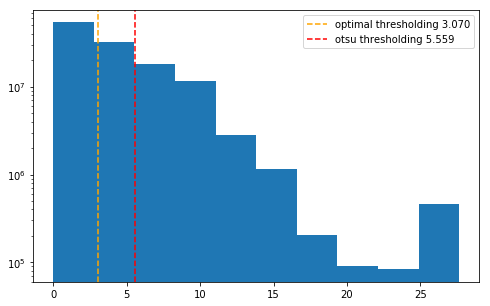

In [15]:
plt.figure(figsize=(8,5))
plt.hist(dissimilarity, bins=10, log=True)
plt.axvline(opt_threshold, color='orange', label = 'optimal thresholding {0:0.3f}'.format(opt_threshold), linestyle='--')
plt.axvline(thresh, color='r', label = 'otsu thresholding {0:0.3f}'.format(thresh), linestyle='--')
plt.legend()
plt.show()

In [60]:
target_[index]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1.]])

In [20]:
# disimilarity = cross_entropy(target_, source_)

In [3]:
# import time
# # from math import log
# def cross_entropy(p, q):
#     # q = q + 1e-12
#     # p = p + 1e-12
#     h = [-((p[i]*np.log(q[i]))).sum() for i in range(len(p))]
#     return np.array(h)

In [45]:
# import time
# def cross_entropy(p, q):
#     # q = q + 1e-15
#     h = [-(xlogy(p[i],q[i])).sum() for i in range(len(p))]
#     return np.array(h)

In [72]:
# cross_entropy(s_soft, t_soft)

In [ ]:
# plt.figure(figsize=(8,5))
# plt.hist(ce1, bins=10, log=True)
# plt.show()

In [19]:
# loss = torch.nn.CrossEntropyLoss()
# t_soft = torch.nn.functional.log_softmax(torch.from_numpy(t_), dim=1)
# s_soft = torch.nn.functional.softmax(torch.from_numpy(s_), dim=1)
# dd = []
# for i in range(len(s_soft)):
#     dist = loss(s_soft[i], t_soft[i])
#     dd.append(dist)

RuntimeError: "softmax_lastdim_kernel_impl" not implemented for 'Half'

In [43]:
# torch.nn.functional.softmax(t_soft, dim=1)

tensor([[0.0497, 0.0496, 0.0531,  ..., 0.0570, 0.0571, 0.0496],
        [0.0496, 0.0496, 0.0520,  ..., 0.0573, 0.0554, 0.0497],
        [0.0497, 0.0498, 0.0516,  ..., 0.0619, 0.0555, 0.0499],
        ...,
        [0.0494, 0.0497, 0.0523,  ..., 0.0524, 0.0522, 0.0495],
        [0.0500, 0.0519, 0.0629,  ..., 0.0565, 0.0518, 0.0498],
        [0.0501, 0.0517, 0.0609,  ..., 0.0547, 0.0515, 0.0499]],
       dtype=torch.float64)

In [9]:
# from math import log2
# # def cross_entropy(p,q):
# #     return -sum([p[i]*log2(q[i]) for i in range(len(p))])
# def cross_entropy(p, q):
#     return -([p[i]*log2(q[i]) for i in range(len(p))])

In [34]:
gt_source_

array([0, 0, 0, ..., 0, 0, 0])

In [35]:
gt_target_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [20]:
# ### confunsion matrix for gt 
# gt_source_ = gt_source_[gt_source_ !=0]
# gt_target_ = gt_target_[gt_target_ !=0]

In [ ]:
ccm = confusion_matrix(gt_source_, gt_target_)

In [9]:
# print("GT 2018: ",gt_source_.shape)
# print("GT 2019: ",gt_target_.shape)
# print("Pred 2018: ",pred_source_.shape)
# print("Pred 2019: ",pred_target_.shape)

In [29]:
# gt_mask = (gt_source_ != 0) & (gt_target_ != 0)
# gt_binary = np.where(gt_mask, np.where(gt_source_ == gt_target_, 1, 2), 0)
# gt_binary_mask = np.ma.masked_array(gt_binary, mask=True)
# gt_binary_mask.mask[gt_binary_mask.data != 0] = False

In [71]:
# ce_mask = np.ma.masked_array(ce1, mask=True)
# ce_mask.mask[gt_binary_mask.data !=0] = False

In [73]:
# similarity_mask

In [25]:
# similarity_mask = np.ma.masked_array(ce1, mask= True)
# similarity_mask.mask[gt_binary_mask.data != 0] = False # extract according to the non-zero from ground truth data
# similarity_ = similarity_mask.compressed()

In [14]:
new_ce = ce_mask.compressed()

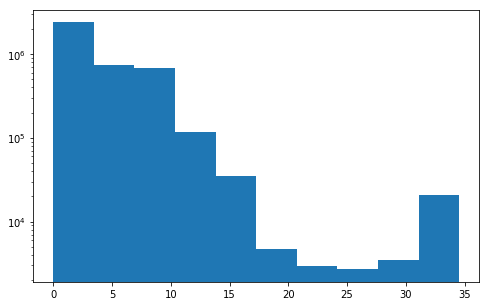

In [15]:
plt.figure(figsize=(8,5))
plt.hist(new_ce, bins=10, log=True)
plt.show()

In [15]:
# np.unique((gt_target_ != 0), return_counts=True)
np.unique(gt_mask_nodata, return_counts=True)

(array([False,  True]), array([116538680,   4021720]))

In [4]:
def mask_and_extract(array, mask_array):
    array = np.ma.masked_array(array, mask=True)
    array.mask[mask_array] = False
    array_value = np.ma.compressed(array)
    return array_value

gt_source_ = mask_and_extract(gt_source_, gt_mask_nodata)
gt_target_ = mask_and_extract(gt_target_, gt_mask_nodata)
pred_source_ = mask_and_extract(pred_source_, gt_mask_nodata)
pred_target_ = mask_and_extract(pred_target_, gt_mask_nodata)

In [5]:
print(gt_source_.shape)
print(gt_target_.shape)
print(pred_source_.shape)
print(pred_target_.shape)

(4021720,)
(4021720,)
(4021720,)
(4021720,)


In [6]:
df = pd.DataFrame({'gt_source': gt_source_, 'gt_target': gt_target_, 'pred_source': pred_source_, 'pred_target': pred_target_})

In [7]:
dict_={1: 'Dense built-up area',
2: 'Diffuse built-up area',
 3: 'Industrial and commercial areas',
 4: 'Roads',
 5: 'Oilseeds (Rapeseed)',
 6: 'Straw cereals (Wheat, Triticale, Barley)',
 7: 'Protein crops (Beans / Peas)',
 8: 'Soy',
 9: 'Sunflower',
 10: 'Corn',
 12: 'Tubers/roots',
 13: 'Grasslands',
 14: 'Orchards and fruit growing',
 15: 'Vineyards',
 16: 'Hardwood forest',
 17: 'Softwood forest',
 18: 'Natural grasslands and pastures',
 19: 'Woody moorlands',
 23: 'Water'}

In [8]:
import time
start_time =time.time()
df['gt_source'] = df['gt_source'].map(dict_)
df['gt_target'] = df['gt_target'].map(dict_)
df['pred_source'] = df['pred_source'].map(dict_)
df['pred_target'] = df['pred_target'].map(dict_)
print(" %s minute" % str((time.time() - start_time)/60))

 0.010157763957977295 minute


In [9]:
import time
start_time =time.time()
df['gt_change']= df.apply(lambda x: str(x['gt_source']) + '-' + str(x['gt_target']), axis=1)
df['pred_change']= df.apply(lambda x: str(x['pred_source']) + '-' + str(x['pred_target']), axis=1)
print(" %s minutes" % str((time.time() - start_time)/60))

 3.382476266225179 minutes


In [10]:
cm = pd.crosstab(df['gt_change'], df['pred_change'], rownames=['Ground Truth'], colnames=['Prediction'])

In [11]:
cm['recall'] = 0
cm.loc['precision'] = 0
cm['f1'] = 0

In [12]:
# df['gt_change'].unique()

In [13]:
for rname in cm.index:
    for cname in cm.columns:
        if rname == cname:
            cm['recall'].loc[rname] = (cm.loc[rname, cname] / cm.sum()[rname]) * 100 
            cm[cname].loc['precision'] = cm.loc[rname, cname] / cm.sum(axis = 1)[cname] * 100
            cm['f1'].loc[rname] = 2 * (cm.loc[rname, 'recall'] * cm.loc['precision', cname]) / (cm.loc[rname, 'recall'] + cm.loc['precision', cname])
            # cm.loc['precision'][cm.columns.get_loc(cname)] = (cm.loc[rname, cname] / cm.sum(axis = 1)[cname]) * 100

/share/etud/e2008987/.local/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/share/etud/e2008987/.conda/envs/python_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [14]:
# cm

In [15]:
cm_ = cm[cm['recall'] != 0]

In [16]:
# cm_

In [17]:
prec = cm.iloc[[-1]]

In [18]:
# prec

In [19]:
prec = prec.loc[:, (prec !=0).any(axis=0)]

In [20]:
prec

Prediction,Corn-Corn,Corn-Oilseeds (Rapeseed),Corn-Protein crops (Beans / Peas),Corn-Soy,"Corn-Straw cereals (Wheat, Triticale, Barley)",Corn-Sunflower,Corn-Tubers/roots,Dense built-up area-Dense built-up area,Diffuse built-up area-Corn,Diffuse built-up area-Diffuse built-up area,...,Tubers/roots-Oilseeds (Rapeseed),Tubers/roots-Soy,"Tubers/roots-Straw cereals (Wheat, Triticale, Barley)",Tubers/roots-Sunflower,Vineyards-Corn,Vineyards-Sunflower,Vineyards-Vineyards,Water-Water,"Woody moorlands-Straw cereals (Wheat, Triticale, Barley)",Woody moorlands-Woody moorlands
Ground Truth,,,,,,,,,,,,,,,,,,,,,
precision,93.488833,67.484507,77.502703,88.67805,93.618885,95.072599,85.168957,12.582224,3.98314,96.860309,...,38.271605,26.39087,84.456494,15.254237,2.008288,35.525652,63.071866,98.931716,0.587002,41.007439


In [21]:
t = prec.T

In [22]:
t['recall'] = cm_['recall']

In [23]:
t

Ground Truth,precision,recall
Prediction,,
Corn-Corn,93.488833,98.020130
Corn-Oilseeds (Rapeseed),67.484507,92.010309
Corn-Protein crops (Beans / Peas),77.502703,92.378991
Corn-Soy,88.678050,95.603496
"Corn-Straw cereals (Wheat, Triticale, Barley)",93.618885,95.020606
...,...,...
Vineyards-Sunflower,35.525652,12.890625
Vineyards-Vineyards,63.071866,99.935653
Water-Water,98.931716,99.904330


In [24]:
t['f1'] = cm_['f1']

In [25]:
t

Ground Truth,precision,recall,f1
Prediction,,,
Corn-Corn,93.488833,98.020130,95.700874
Corn-Oilseeds (Rapeseed),67.484507,92.010309,77.861720
Corn-Protein crops (Beans / Peas),77.502703,92.378991,84.289500
Corn-Soy,88.678050,95.603496,92.010641
"Corn-Straw cereals (Wheat, Triticale, Barley)",93.618885,95.020606,94.314538
...,...,...,...
Vineyards-Sunflower,35.525652,12.890625,18.917103
Vineyards-Vineyards,63.071866,99.935653,77.335428
Water-Water,98.931716,99.904330,99.415644


In [26]:
t.index.name = None

In [27]:
t

Ground Truth,precision,recall,f1
Corn-Corn,93.488833,98.020130,95.700874
Corn-Oilseeds (Rapeseed),67.484507,92.010309,77.861720
Corn-Protein crops (Beans / Peas),77.502703,92.378991,84.289500
Corn-Soy,88.678050,95.603496,92.010641
"Corn-Straw cereals (Wheat, Triticale, Barley)",93.618885,95.020606,94.314538
...,...,...,...
Vineyards-Sunflower,35.525652,12.890625,18.917103
Vineyards-Vineyards,63.071866,99.935653,77.335428
Water-Water,98.931716,99.904330,99.415644
"Woody moorlands-Straw cereals (Wheat, Triticale, Barley)",0.587002,5.714286,1.064639


In [28]:
t.columns.name = None

In [29]:
# t.reset_index(drop=True, inplace=True)

In [30]:
t['changes'] = t.index
t

,precision,recall,f1,changes
Corn-Corn,93.488833,98.020130,95.700874,Corn-Corn
Corn-Oilseeds (Rapeseed),67.484507,92.010309,77.861720,Corn-Oilseeds (Rapeseed)
Corn-Protein crops (Beans / Peas),77.502703,92.378991,84.289500,Corn-Protein crops (Beans / Peas)
Corn-Soy,88.678050,95.603496,92.010641,Corn-Soy
"Corn-Straw cereals (Wheat, Triticale, Barley)",93.618885,95.020606,94.314538,"Corn-Straw cereals (Wheat, Triticale, Barley)"
...,...,...,...,...
Vineyards-Sunflower,35.525652,12.890625,18.917103,Vineyards-Sunflower
Vineyards-Vineyards,63.071866,99.935653,77.335428,Vineyards-Vineyards
Water-Water,98.931716,99.904330,99.415644,Water-Water
"Woody moorlands-Straw cereals (Wheat, Triticale, Barley)",0.587002,5.714286,1.064639,"Woody moorlands-Straw cereals (Wheat, Tritical..."


In [31]:
t.reset_index(drop=True, inplace=True)

In [32]:
t

,precision,recall,f1,changes
0,93.488833,98.020130,95.700874,Corn-Corn
1,67.484507,92.010309,77.861720,Corn-Oilseeds (Rapeseed)
2,77.502703,92.378991,84.289500,Corn-Protein crops (Beans / Peas)
3,88.678050,95.603496,92.010641,Corn-Soy
4,93.618885,95.020606,94.314538,"Corn-Straw cereals (Wheat, Triticale, Barley)"
...,...,...,...,...
65,35.525652,12.890625,18.917103,Vineyards-Sunflower
66,63.071866,99.935653,77.335428,Vineyards-Vineyards
67,98.931716,99.904330,99.415644,Water-Water
68,0.587002,5.714286,1.064639,"Woody moorlands-Straw cereals (Wheat, Tritical..."


In [33]:
def check_semantic_change(change_str):
    change_str = change_str.split("-")
    if change_str[0] == change_str[1]:
        return "no change"
    else:
        return "change"
    

In [34]:
t['cat'] = t['changes'].apply(check_semantic_change)

In [35]:
t['cat'].value_counts()

change       55
no change    15
Name: cat, dtype: int64

In [36]:
t_change = t[t['cat'] == 'change'].sort_values(by=['f1'], ascending=False)

In [37]:
t_change

,precision,recall,f1,changes,cat
56,99.165687,97.145470,98.145183,"Sunflower-Straw cereals (Wheat, Triticale, Bar...",change
50,98.869942,96.723090,97.784734,"Straw cereals (Wheat, Triticale, Barley)-Sunfl...",change
24,96.458345,97.815936,97.132397,"Oilseeds (Rapeseed)-Straw cereals (Wheat, Trit...",change
46,95.856579,96.398096,96.126574,"Straw cereals (Wheat, Triticale, Barley)-Oilse...",change
20,93.945905,97.677275,95.775261,Oilseeds (Rapeseed)-Corn,change
4,93.618885,95.020606,94.314538,"Corn-Straw cereals (Wheat, Triticale, Barley)",change
5,95.072599,93.257663,94.156386,Corn-Sunflower,change
45,94.532172,93.102010,93.811641,"Straw cereals (Wheat, Triticale, Barley)-Corn",change
59,86.884715,100.000000,92.982152,Tubers/roots-Corn,change
40,90.438692,95.159288,92.738957,Soy-Protein crops (Beans / Peas),change


In [38]:
t_nochange = t[t['cat'] == 'no change'].sort_values(by=['f1'], ascending=False)

In [39]:
t_nochange

,precision,recall,f1,changes,cat
67,98.931716,99.904330,99.415644,Water-Water,no change
0,93.488833,98.020130,95.700874,Corn-Corn,no change
16,96.498715,93.692664,95.074989,Hardwood forest-Hardwood forest,no change
41,90.215872,96.837583,93.409523,Soy-Soy,no change
38,85.679214,96.729708,90.869737,Softwood forest-Softwood forest,no change
27,79.814496,99.812229,88.700195,Orchards and fruit growing-Orchards and fruit ...,no change
13,83.458372,92.534006,87.762181,Grasslands-Grasslands,no change
37,69.735723,97.855316,81.436469,Roads-Roads,no change
17,68.623238,94.433259,79.485530,Industrial and commercial areas-Industrial and...,no change
66,63.071866,99.935653,77.335428,Vineyards-Vineyards,no change


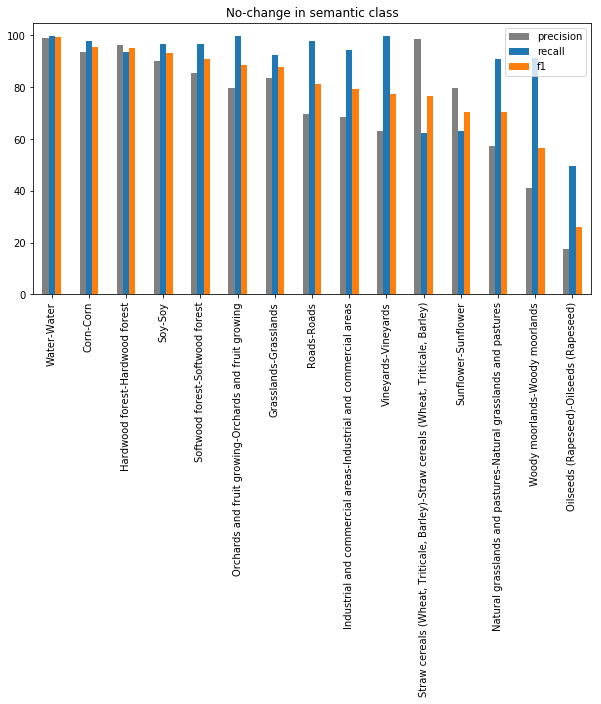

In [84]:
# t_nochange.plot.bar(rot=0, figsize=(10,5), fontsize=10, color=['gray', '#1F77B4', '#FF7F0E'])
# plt.xticks(range(len(t_nochange)), t_nochange['changes'], rotation=90)
# plt.title('No-change in semantic class')
# # plt.savefig("./charts/semantic-nochange.png", dpi=3000)
# plt.show()

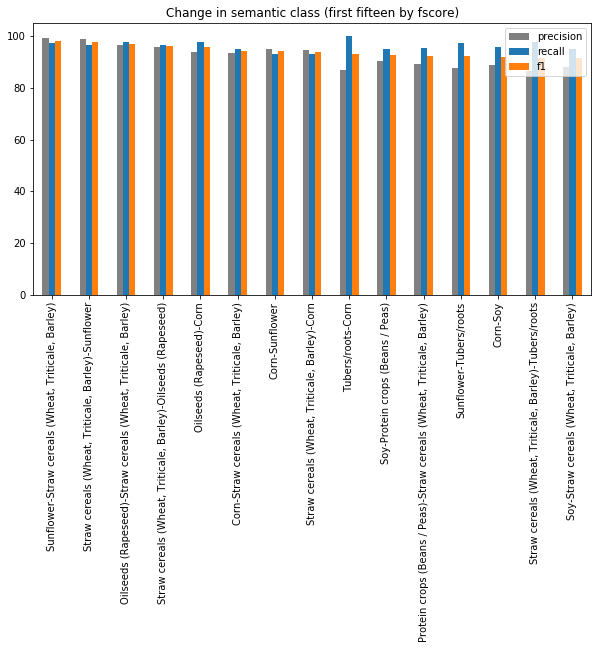

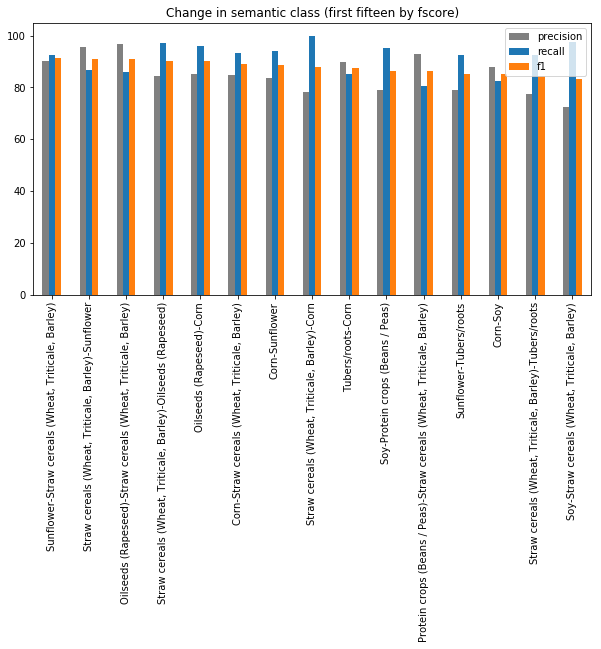

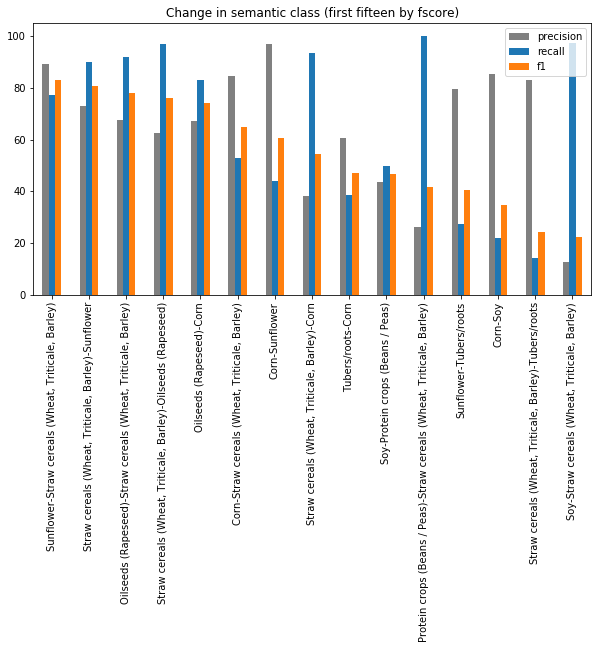

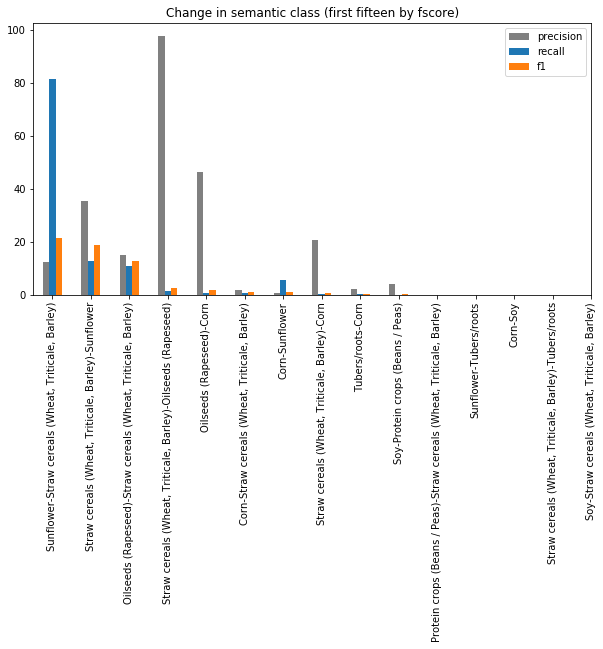

In [57]:
start = 0
stop = len(t_change)
interval = 15

for i in range(start, stop, interval):
    # print(t_change[i:(i +interval)])
    t_change[i:(i + interval)].plot.bar(rot=0, figsize=(10,5), fontsize=10, color=['gray', '#1F77B4', '#FF7F0E'])
    plt.xticks(range(len(t_change.iloc[:15,-2])), t_change.iloc[:15,-2], rotation=90)
    plt.title('Change in semantic class (first fifteen by fscore)')
    # plt.savefig("./charts/semantic-change.png", dpi=3000)
    plt.show()

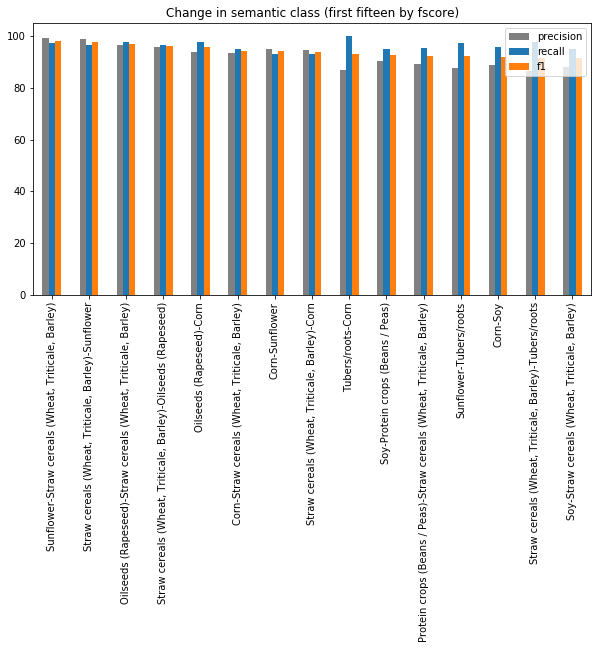

In [88]:
t_change.iloc[:15, :].plot.bar(rot=0, figsize=(10,5), fontsize=10, color=['gray', '#1F77B4', '#FF7F0E'])
plt.xticks(range(len(t_change.iloc[:15,-2])), t_change.iloc[:15,-2], rotation=90)
plt.title('Change in semantic class (first fifteen by fscore)')
# plt.savefig("./charts/semantic-change.png", dpi=3000)
plt.show()

In [60]:
len(t_change.iloc[:15, -2])

15

In [31]:
t.to_csv('t.csv')

In [32]:
t = t.sort_values('f1', ascending=False)

In [33]:
t.to_csv('t_sort.csv')

In [114]:
# cm_group = cm.groupby('f1')

In [115]:
# cm_group.boxplot()

In [118]:
# prec